# E-commerce Fraud Detection Analysis

### Load libraries

In [36]:
import pandas as pd
import pickle
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix,  roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

from collections import Counter

from skopt import BayesSearchCV

from imblearn.under_sampling import RandomUnderSampler # doctest: +NORMALIZE_WHITESPACE
from imblearn.pipeline import Pipeline # doctest: +NORMALIZE_WHITESPACE

%matplotlib inline

### Load data

Logistic Regression and Random Forest are used on cleanXG_LR.zip dataset. This data set have 2 type of data X1 and X2 with following specifications:
- General - Preprocessing applied to all files:
    - Features with > 90% data missing or > 90% data with the same value were dropped
    - If possible, categorical variables with 100s of categories were mapped to coaser categoricals
    - Correlation plot analysis done on "V" columns and columns were dropped reduce collinearlity
        - https://www.kaggle.com/cdeotte/eda-for-columns-v-and-id
    - Some "D" columns were normalized for time
    - Aggregate features were added using "magic" technique
        - https://www.kaggle.com/cdeotte/xgb-fraud-with-magic-0-9600#How-the-Magic-Works
    - Dropped TransactionID and TransactionDT

- XGBoost_LR_{train, test}_X_1.pkl ==> 1323 features
    - Full 200 features
	- Dummies created
    - NAs filled with -999
- XGBoost_LR_{train, test}_X_2.pkl ==> 1303 features
    - Removed additional features:
        - Highly correlated "C", "D" features
        - Removed features Chris (1st place winners) removed
        - Removed caterogical features withh 200+ categories even after 1)
    - Dummies created
    - NAs filled with -999


In [2]:
#Load train y data
y = pd.read_pickle("data/train_y.pkl")


In [3]:
#Load train x data
X = pd.read_pickle("data/cleanXG_LR/XGBoost_LR_train_X_1.pkl")

# Replace Nan (currently -999 in the input dataset) with 0:
X = X.replace(-999, 0)

In [4]:
y.shape, X.shape

((590540,), (590540, 1323))

In [5]:
X.head(3)

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,...,DeviceInfo_za409,DeviceInfo_za509,DeviceInfo_za990,DeviceInfo_zeia8,DeviceInfo_zte,DeviceInfo_zte a2017u build/nrd90m,DeviceInfo_zte-z835,DeviceInfo_zte-z956,DeviceInfo_zur70016,DeviceInfo_zuum_zen_i build/lrx21m
0,0.0,70787.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,-5.0,98945.0,0.0,0.0,0.0,-5.0,0.0,0.0,100.0,49.0,...,0,0,0,0,0,0,0,0,0,0
2,-5.0,191631.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,52.0,...,0,0,0,0,0,0,0,0,0,0


### Logistic Regression - 2 nested train-test split

### Part A: Parameter tuning on training data (A)

In [6]:
# Specify parameters
seed = 123
test_size = 0.3 #Testing percentage in train/test split

In [7]:
# Get a subset of data for debugging
X = X.iloc[:10000,:]
y = y.iloc[:10000]

In [8]:
# Outer validation for model family comparison: slipt data into training (A) and testing (B)
X_A, X_B, y_A, y_B = train_test_split(X, y, test_size = test_size, random_state = seed)

# Reset all indices
X_A.reset_index(drop = True, inplace = True)
X_B.reset_index(drop = True, inplace = True)
y_A.reset_index(drop = True, inplace = True)
y_A.reset_index(drop = True, inplace = True)

In [9]:
# Inner validation for parameter tuning within a model family: split data into training (C) and testing (D)
# Set up train-test split validation
A_ind = np.arange(len(X_A))
C_ind, D_ind = train_test_split(A_ind, test_size = test_size, random_state = seed)

X_C = X_A.iloc[C_ind,:]
y_C = y_A.iloc[C_ind]
#print(X_C.head(2))

# Reformat index array to 2D list to be used within "cv" context:
# Desired format: [ ( [train_ind_fold1], [test_ind_fold1]) , ([train_ind_fold2], [test_ind_fold2]) ]
C_ind = list(C_ind) #Train
D_ind = list(D_ind) #Test
cv = [(C_ind, D_ind)] #(Train indices, Test indices)
#list(cv)

In [10]:
#Get numeric features that need to be scaled to mean 0 and unit variance and unimodal variables to exclude 

numeric_features = []

for colname in X_C.columns:
    if len(np.unique(X_C[colname])) > 2:
        numeric_features.append(colname)
        
print('There are %d/%d numeric features that needs to be scaled' %(len(numeric_features), X_C.shape[1]))

There are 152/1323 numeric features that needs to be scaled


In [52]:
#Build pipeline to include preprocessing step of scaling multivariate numeric features.
numeric_transformer = Pipeline([
        ('scaler', StandardScaler())
    ])

preprocessor = ColumnTransformer([
        ('numericals', numeric_transformer, numeric_features)
    ])

ratio = 1 #Ratio of fraud to non-fraud. Ratio = 1 means no. fraud = no. non-fraud

pipeline = Pipeline([
        ('sampler', RandomUnderSampler(ratio)),
        ('preprocessing', preprocessor),
        ('clf',LogisticRegression(class_weight = 'balanced', random_state = seed))
    ])


In [53]:
#Set up search space for parameter
#Set up search space for parameter
params = {   
        'clf__solver': ['newton-cg'],
        'clf__max_iter': [100,200],
        'clf__penalty': ['none', 'l2'],
        'clf__C': [0.0001, 10]
    }

In [54]:
lr_tuner = BayesSearchCV(estimator = pipeline, search_spaces = params, scoring = 'roc_auc',\
                          cv = cv, n_jobs = 3, n_iter = 5, verbose = 1, refit = True, random_state = seed)

In [55]:
def status_print(optim_result):    
    all_models = pd.DataFrame(lr_tuner.cv_results_)    
    
    # Get best parameters    
    best_params = pd.Series(lr_tuner.best_params_)
    print(f'Model {len(all_models)}:\nBest ROC-AUC:\
    {np.round(lr_tuner.best_score_, 4)}\nBestparams:{lr_tuner.best_params_}\n')
    
    # Save to csv
    #clf_name = rg_tuner.estimator.__class__.__name__
    #all_models.to_csv(clf_name+"_cv_results.csv")

In [56]:
print('Modeling..')
best_lr = lr_tuner.fit(X_A, y_A, callback = status_print)

Modeling..
Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:   10.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Model 1:
Best ROC-AUC:    0.8348
Bestparams:OrderedDict([('clf__C', 8.586951828215655), ('clf__max_iter', 137), ('clf__penalty', 'none'), ('clf__solver', 'newton-cg')])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    8.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Model 2:
Best ROC-AUC:    0.8448
Bestparams:OrderedDict([('clf__C', 9.925181822183777), ('clf__max_iter', 176), ('clf__penalty', 'l2'), ('clf__solver', 'newton-cg')])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:   10.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Model 3:
Best ROC-AUC:    0.8448
Bestparams:OrderedDict([('clf__C', 9.925181822183777), ('clf__max_iter', 176), ('clf__penalty', 'l2'), ('clf__solver', 'newton-cg')])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Model 4:
Best ROC-AUC:    0.8448
Bestparams:OrderedDict([('clf__C', 9.925181822183777), ('clf__max_iter', 176), ('clf__penalty', 'l2'), ('clf__solver', 'newton-cg')])

Fitting 1 folds for each of 1 candidates, totalling 1 fits


[Parallel(n_jobs=3)]: Done   1 out of   1 | elapsed:    2.1s finished


Model 5:
Best ROC-AUC:    0.8448
Bestparams:OrderedDict([('clf__C', 9.925181822183777), ('clf__max_iter', 176), ('clf__penalty', 'l2'), ('clf__solver', 'newton-cg')])



In [57]:
best_lr.cv_results_ 
#Note each split is a fold. Since we are doing only train/test split, fold = 1 and we only have "split0". 
#In each metric, there are n_iters values. Each n_iter corresponds to a set of parameters. Here, we tried 5 sets corresponding 5 values.

defaultdict(list,
            {'split0_test_score': [0.8348402022893271,
              0.844762568957525,
              0.7991180118517157,
              0.7992349420986473,
              0.8080214149395094],
             'mean_test_score': [0.8348402022893271,
              0.844762568957525,
              0.7991180118517157,
              0.7992349420986473,
              0.8080214149395094],
             'std_test_score': [0.0, 0.0, 0.0, 0.0, 0.0],
             'rank_test_score': [2, 1, 5, 4, 3],
             'mean_fit_time': [1.3390026092529297,
              0.5699992179870605,
              2.6840085983276367,
              0.7230007648468018,
              1.925978183746338],
             'std_fit_time': [0.0, 0.0, 0.0, 0.0, 0.0],
             'mean_score_time': [0.01799631118774414,
              0.015000581741333008,
              0.012996673583984375,
              0.01700592041015625,
              0.013997793197631836],
             'std_score_time': [0.0, 0.0, 0.0, 0.0, 0.

In [58]:
best_lr.best_params_

OrderedDict([('clf__C', 9.925181822183777),
             ('clf__max_iter', 176),
             ('clf__penalty', 'l2'),
             ('clf__solver', 'newton-cg')])

### Part B: Retrain model on entire training data (A) and apply on validation data (B)

##### Build Model

In [59]:
# Proprocess data on A - feature scaling

# Step 1: get list of feature to scale
# Numeric features are those that have more than 2 levels.
# We will scale these features to have mean 0 and unit variance and unimodal variables to exclude 

numeric_features = []
thres = 5 #5% of feature value is 1
for colname in X_A.columns:
    if len(np.unique(X_A[colname])) > 2:
        numeric_features.append(colname)

print('There are %d/%d numeric features that needs to be scaled' %(len(numeric_features), X_A.shape[1]))

# Step 2: train scaler using training data (A) only
scaler = StandardScaler().fit(X_A[numeric_features])
    
# Step 3: apply scaler on  training data (A) and testing data (B)
X_A.loc[:,numeric_features] = scaler.transform(X_A.loc[:,numeric_features])
X_B.loc[:,numeric_features] = scaler.transform(X_B.loc[:,numeric_features])

# Sanity check:
rand_ind_check = np.random.randint(len(numeric_features))
print('mean = 0 and variance = 1')
print(np.mean(X_A.loc[:,numeric_features[rand_ind_check]]), np.std(X_A.loc[:,numeric_features[rand_ind_check]])**2)

There are 152/1323 numeric features that needs to be scaled


C:\Users\MyPC\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\MyPC\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


mean = 0 and variance = 1
4.398465718631022e-16 1.0000000000000773


In [60]:
# Proprocess data on A - data balancing
X_A_arr, y_A_arr = X_A.to_numpy(), y_A.to_numpy()

#Before balancing
print('Original dataset shape %s' % Counter(y_A))

#Undersampling without replacement
rus = RandomUnderSampler(sampling_strategy = ratio, random_state = seed)
X_A_res, y_A_res = rus.fit_resample(X_A_arr, y_A_arr)
print('Resampled dataset shape %s' % Counter(y_A_res))
    
#In order to use sklearn model, we need input to be in dataframe format. Convert balanced numpy data to dataframe:
X_A_res = pd.DataFrame(data = X_A_res, columns = X_A.columns)
y_A_res = pd.Series(data = y_A_res).rename(y_A.name)

Original dataset shape Counter({0: 6646, 1: 354})
Resampled dataset shape Counter({0: 354, 1: 354})


In [61]:
X_A_res.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_09,id_10,id_11,id_13,...,DeviceInfo_za409,DeviceInfo_za509,DeviceInfo_za990,DeviceInfo_zeia8,DeviceInfo_zte,DeviceInfo_zte a2017u build/nrd90m,DeviceInfo_zte-z835,DeviceInfo_zte-z956,DeviceInfo_zur70016,DeviceInfo_zuum_zen_i build/lrx21m
0,0.583651,-0.548831,-0.10142,0.061866,-0.351695,0.359699,-0.098922,0.100737,0.180226,-1.659100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.222972,-0.700881,-0.10142,0.061866,-0.351695,0.359699,-0.098922,0.100737,0.180226,0.700163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.222972,0.153005,-0.10142,0.061866,-0.351695,0.297301,-0.098922,0.100737,0.180226,0.700163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.583651,-0.176050,-0.10142,0.061866,-0.351695,0.359699,1.142036,0.100737,-0.029024,0.201088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.222972,-1.012402,-0.10142,0.061866,-0.351695,0.297301,-0.098922,0.100737,0.180226,0.700163,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
'''
('clf__C', 9.925181822183777),
             ('clf__max_iter', 176),
             ('clf__penalty', 'l2'),
             ('clf__solver', 'newton-cg')])
'''

In [62]:
# Build model using best hyperparameters found and all training data (A)
lr = LogisticRegression(
                        class_weight = 'balanced',    
                        C = best_lr.best_params_['clf__C'],
                        solver = best_lr.best_params_['clf__solver'],
                        max_iter = best_lr.best_params_['clf__max_iter'],
                        penalty = best_lr.best_params_['clf__penalty'],
                        random_state = seed)
lr.fit(X_A, y_A)


LogisticRegression(C=9.925181822183777, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=176, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

##### Feature Importance

In [83]:
# Saving feature names for later use
feature_list = list(X_A.columns)
# Get numerical feature importances
importances = np.abs(lr.coef_)[0].tolist()
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: C14                  Importance: 18.17
Variable: C8                   Importance: 15.61
Variable: C11                  Importance: 12.59
Variable: DeviceInfo_vs995 build/nrd90m Importance: 10.39
Variable: ProductCD_R          Importance: 7.54
Variable: DeviceInfo_z983 build/nmf26f Importance: 6.76
Variable: DeviceInfo_nx785qc8g Importance: 6.72
Variable: DeviceInfo_f5121 build/34.3.a.0.228 Importance: 6.6
Variable: DeviceInfo_htc       Importance: 6.35
Variable: id_33_3840x2160      Importance: 5.95
Variable: ProductCD_S          Importance: 5.78
Variable: DeviceInfo_kffowi build/lvy48f Importance: 5.22
Variable: id_33_1280x720       Importance: 5.19
Variable: C7                   Importance: 5.13
Variable: id_30_Android 6.0.1  Importance: 4.83
Variable: id_33_1280x1024      Importance: 4.71
Variable: DeviceInfo_macos     Importance: 4.65
Variable: DeviceInfo_trident/7.0 Importance: 4.65
Variable: V165                 Importance: 4.57
Variable: C10                  Importance

Variable: DeviceInfo_g630-u251 Importance: 0.0
Variable: DeviceInfo_g8141     Importance: 0.0
Variable: DeviceInfo_g8141 build/47.1.a.5.51 Importance: 0.0
Variable: DeviceInfo_g8142     Importance: 0.0
Variable: DeviceInfo_g8341     Importance: 0.0
Variable: DeviceInfo_gigaset   Importance: 0.0
Variable: DeviceInfo_grace     Importance: 0.0
Variable: DeviceInfo_grand     Importance: 0.0
Variable: DeviceInfo_grand2c   Importance: 0.0
Variable: DeviceInfo_grant     Importance: 0.0
Variable: DeviceInfo_gravity build/nrd90m Importance: 0.0
Variable: DeviceInfo_gxq6580_weg_l build/lmy47i Importance: 0.0
Variable: DeviceInfo_h1611     Importance: 0.0
Variable: DeviceInfo_h3321     Importance: 0.0
Variable: DeviceInfo_h550      Importance: 0.0
Variable: DeviceInfo_helio     Importance: 0.0
Variable: DeviceInfo_helix     Importance: 0.0
Variable: DeviceInfo_hi6210sft build/mra58k Importance: 0.0
Variable: DeviceInfo_highway   Importance: 0.0
Variable: DeviceInfo_hp        Importance: 0.0
Varia

##### Test model and report performance metrics

In [84]:
# Apply model on testing data (B) and report performance metrics:
y_B_pred_labels = lr.predict(X_B)

AUC =  0.9275770434782609


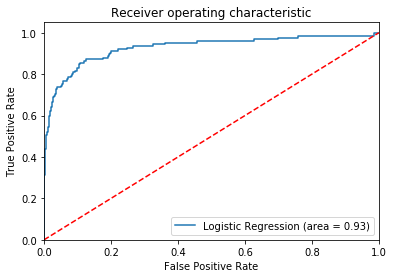

In [85]:
# Get probability of class 1 to get cut-off values
y_B_pred_prob = lr.predict_proba(X_B)

logit_roc_auc = roc_auc_score(y_B, y_B_pred_prob[:,1])
fpr, tpr, _ = roc_curve(y_B, y_B_pred_prob[:,1])

print('AUC = ', logit_roc_auc)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()


Confusion Matrix (Note: this result is not a good representation as it assumes 2 classes weight the same)


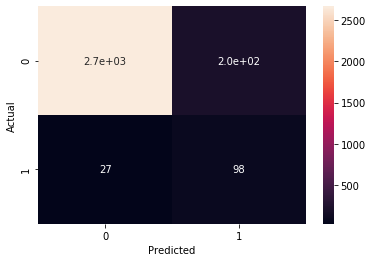

In [86]:
print('Confusion Matrix (Note: this result is not a good representation as it assumes 2 classes weight the same)')


data = {'y_Actual':    list(y_B),
        'y_Predicted': list(y_B_pred_labels)
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sb.heatmap(confusion_matrix, annot=True)
plt.show()